In [1]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

2024-02-27 18:27:58.324385: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



In [2]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [3]:
def vqc(qubits,n_layers):   

    n_qubits = len(qubits)

    varparams = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    varparams = np.asarray(varparams)
    varparams = varparams.reshape(n_layers+1,n_qubits,3)

    encodparams = sympy.symbols(f'x(0:{(n_layers)})'+f'_(0:{n_qubits})')
    encodparams = np.asarray(encodparams)
    encodparams = encodparams.reshape(n_layers,n_qubits)

    circuit = cirq.Circuit()
    for j in range(n_layers):
        circuit += cirq.Circuit(one_qubit_rotation(val,varparams[j,cnt]) for cnt,val in enumerate(qubits))
        circuit += entangling_layer(qubits)

        circuit += cirq.Circuit(cirq.rx(encodparams[j,cnt])(val) for cnt,val in enumerate(qubits))

    circuit += cirq.Circuit(one_qubit_rotation(val,varparams[-1,cnt]) for cnt,val in enumerate(qubits))

    return circuit , list(varparams.flat) , list(encodparams.flat)

In [4]:
class DataReuploadVQC(tf.keras.layers.Layer):

    def __init__(self, qubits, n_layers, obs, activation='linear', name='reuploadingVQC'):
        super(DataReuploadVQC, self).__init__(name=name)

        self.n_qubits = len(qubits)
        self.n_layers = n_layers

        circuit, theta_symbols, encode_symbols = vqc(qubits,n_layers)

        init_theta = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(initial_value=init_theta(shape=(1,len(theta_symbols))), 
                                 trainable=True,
                                 dtype='float32',
                                 name='thetas')
        
        init_lmbda= tf.ones(shape=(self.n_qubits*n_layers,))
        self.lmbda = tf.Variable(initial_value=init_lmbda,
                                 trainable=True,
                                 dtype='float32',
                                 name='lambdas')
        
        symbols = [str(symb) for symb in theta_symbols + encode_symbols]
        self.indices = tf.constant([symbols.index(i) for i in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit,obs)

    
    def call(self,inputs):

        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim,1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbda, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])    

In [5]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self,output_dim):
        super(Alternating,self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")
        
    def call(self,inputs):
        return tf.matmul(inputs, self.w)

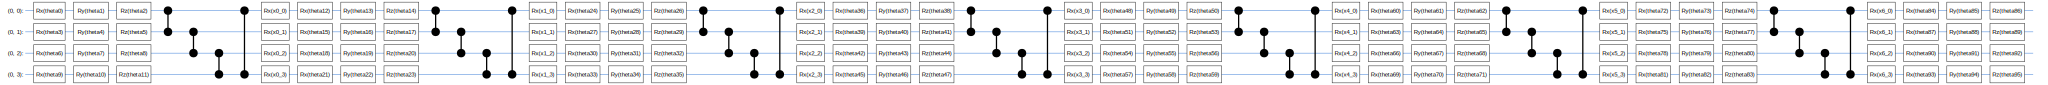

In [6]:
n_qubits = 4
qubits= cirq.GridQubit.rect(1,n_qubits)
n_layers = 7
n_actions = 2
temperature = 1.0
observables = [reduce((lambda x, y: x * y), [cirq.Z(q) for q in qubits])]

circuit,_,_ = vqc(qubits,n_layers)
SVGCircuit(circuit)

In [7]:
def generate_model_policy(qubits, n_layers, n_actions, temperature, observables):

    n_qubits = len(qubits)
    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = DataReuploadVQC(qubits,n_layers,observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * temperature),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor],outputs=policy)

    return model

model= generate_model_policy(qubits,n_layers, n_actions, temperature, observables)  #generates the PQC model that's used in all cells below

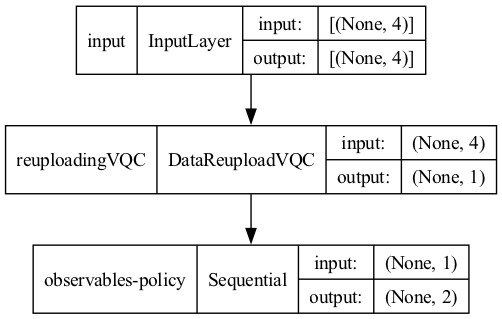

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [9]:
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    
    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)] 

    done=[False for _ in range(n_episodes)] #if False, episode not completed
    states = [e.reset() for e in envs]  #sets all current states to initial state

    while not all(done):    #while every episode has not finished
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]  #stores the indexes of the unfinished episodes
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)   #stores current state

        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states]) #calculates the action probabilities for a given state
        states = [None for _ in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=policy)  #samples an action
            states[i], reward, done[i], _ = envs[i].step(action)    #takes an action, done[i] i assume is only changed to True if final state is achieved (or max reward maybe)
            trajectories[i]['actions'].append(action)   #stores the action
            trajectories[i]['rewards'].append(reward)   #stores the reward
    
    return trajectories

In [10]:
def compute_returns(rewards_history, gamma):
    returns = []
    discounted_sum = 0

    for r in rewards_history[::-1]:     #starts from the last rewards achieved ([::1])
        discounted_sum = r + gamma * discounted_sum #discounted reward
        returns.insert(0, discounted_sum)   #inserts at the start of a list the discounted sum on each step

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()
    return returns

In [11]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
n_episodes = 1000

optimizer_in = tf.keras.optimizers.Adam(learning_rate= 0.1, amsgrad=True)
optimizer_vqc = tf.keras.optimizers.Adam(learning_rate= 0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate= 0.1, amsgrad=True)

w_in, w_vqc, w_out = 1, 0, 2

In [12]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)   #converts everything to tensor. i assume its because
    actions = tf.convert_to_tensor(actions) #to work with the VQC things have to be in tensors
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)   #cant really understand this GradientTape, but it monitors the variables 
        logits = model(states)  #inputs the states to the model. logits should be the action probability in each given state
        p_actions = tf.gather_nd(logits, actions)  #dont understand what this does 
        log_probs = tf.math.log(p_actions)  #logarithm of probabilities can be beneficial
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size

    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_vqc, optimizer_out],[w_in, w_vqc, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])   #w are the index of each optimizer

In [13]:
env_name = "CartPole-v1"

episode_reward_history = []
for batch in range(n_episodes // batch_size):
    episodes = gather_episodes(state_bounds, n_actions, model, batch_size, env_name)

    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]

    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i,a] for i, a in enumerate(actions)])
    
    reinforce_update(states, id_action_pairs, returns, model)

    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)
    
    if avg_rewards >= 500.0:
        break

Finished episode 10 Average rewards:  20.6
Finished episode 20 Average rewards:  26.1
Finished episode 30 Average rewards:  21.8
Finished episode 40 Average rewards:  29.1
Finished episode 50 Average rewards:  36.1
Finished episode 60 Average rewards:  57.0
Finished episode 70 Average rewards:  77.2
Finished episode 80 Average rewards:  90.7
Finished episode 90 Average rewards:  122.1
Finished episode 100 Average rewards:  150.9
Finished episode 110 Average rewards:  135.2
Finished episode 120 Average rewards:  205.5
Finished episode 130 Average rewards:  202.1
Finished episode 140 Average rewards:  250.5
Finished episode 150 Average rewards:  297.8
Finished episode 160 Average rewards:  419.1
Finished episode 170 Average rewards:  495.4
Finished episode 180 Average rewards:  494.0
Finished episode 190 Average rewards:  500.0


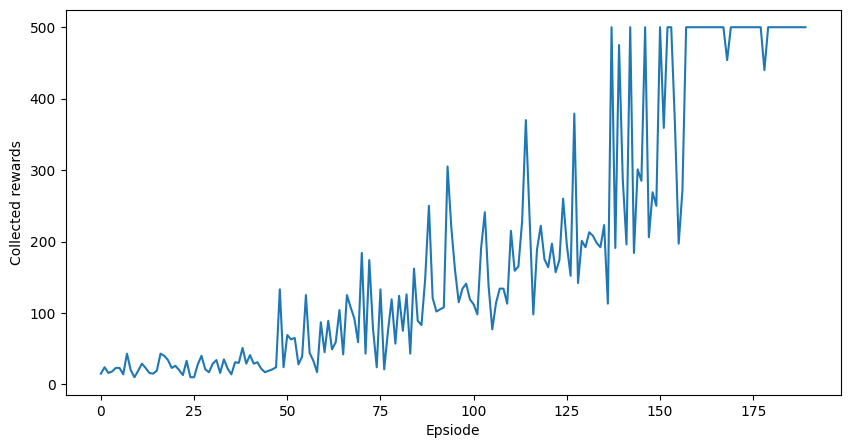

In [14]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()